In [2]:
import sys
sys.path.append("./FY2017_twada/01_WIP/chainer-spectroscopic-measurement")

cnf_file = "./FY2017_twada/01_WIP/chainer-spectroscopic-measurement/net_config/deepnet_config.yaml"

In [18]:
from models import deepnet1b, deepnet1c
from dataset import load_regression
from utils import now
import yaml
from chainer.dataset import convert, concat_examples
from chainer.datasets import tuple_dataset
from chainer import iterators, serializers, training, reporter
import chainer.functions as F
import chainer.links as L
import numpy
import matplotlib

%matplotlib inline

In [9]:
data, ref_values = load_regression(fname="./00_Data/CP.xls")
batch_size = 35

Load :: MS-Excel file: ./00_Data/CP.xls


In [10]:
n_ref = len(ref_values)
num_test = 47

id_train = numpy.arange(n_ref)[num_test:]
id_test = numpy.arange(n_ref)[:num_test]

num_train = len(id_train)
num_test = n_ref - num_train

x_train, y_train = data[:, id_train], ref_values[id_train]
x_test, y_test = data[:, id_test], ref_values[id_test]

train = tuple_dataset.TupleDataset(x_train.reshape(-1, num_train).T,
                                   y_train.reshape(num_train, 1))
test = tuple_dataset.TupleDataset(
    x_test.reshape(-1, num_test).T, y_test.reshape(num_test, 1))

# mini-batch
train_iter = iterators.SerialIterator(train, batch_size,
                                      shuffle=True)
test_iter = iterators.SerialIterator(test, num_test,
                                     repeat=False, shuffle=False)


In [11]:
test_iter.reset()
test_batch = test_iter.next()
test_spc, test_ref = concat_examples(test_batch)  # Test Dataset

# forward = model.forward(test_spc)
# ret_layer = forward[layer_num][spec_id]

# ret_layer.reshape(filters, -1).shape

In [15]:

from models import *
import chainer.functions as F
model = deepnet1c(conf_yaml=cnf_file,
#                   net_yaml=out2
                 )
chainer.serializers.load_hdf5("./Result20180126/model_id.130300.deepnet1c.hdf5", model)

In [70]:
# x = test_spc.reshape(test_spc.shape[0], 1, -1, 1)

# h1 = F.relu(model.conv1(x))
# # h2 = F.max_pooling_2d(F.local_response_normalization(
# #     self.activation(self.conv2(h1))), self.pooling[0])
# h2 = F.max_pooling_2d(F.relu(model.conv2(h1)), 2)

# h3 = F.relu(model.conv3(h2))
# h4 = F.max_pooling_2d(F.relu(model.conv4(h3)), 2)

# h5 = F.relu(model.conv5(h4))
# h6 = F.max_pooling_2d(F.relu(model.conv6(h5)), 2)

# # Affine Layers
# h7 = F.relu(model.affine1(h6))
# if chainer.config.train:  # パラメータ更新時のみ
#     h7 = F.dropout(h7, ratio=0)


# model.affine2(h7)

In [71]:
err = numpy.absolute(test_ref - model.forward(test_spc)[0].data)[:,0] * 100


TypeError: 'int' object has no attribute '__getitem__'

In [14]:
print("|err| < 2.5: %d/%d" % (len(numpy.where(err < 2.5)[0]), len(err)))
print("|err| < 5: %d/%d" % (len(numpy.where(err < 5)[0]), len(err)))
print("|err| < 10: %d/%d" % (len(numpy.where(err < 10)[0]), len(err)))

NameError: name 'err' is not defined

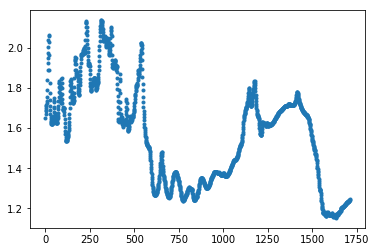

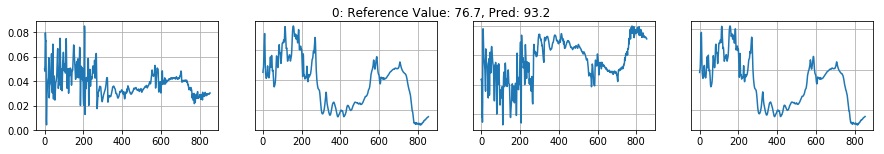

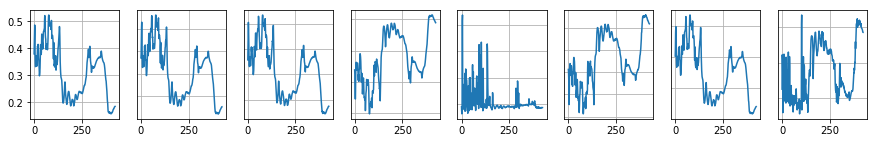

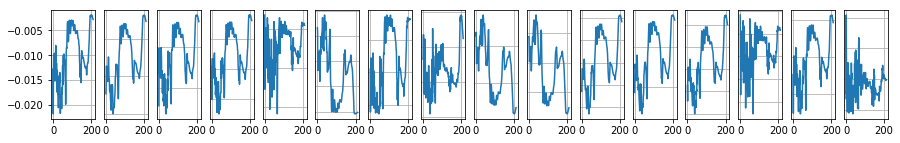

In [37]:
spec_id = 0
matplotlib.pyplot.plot(data[:,0], ".")

for spec_id in range(1):
    for layer_num in (2, 4, 6):
        forward = model.forward(test_spc)
        ret_layer = forward[layer_num][spec_id]
#         print ret_layer.shape[0]
        print_ref = test_ref[spec_id] * 100
        pred_val = forward[0][spec_id].data * 100

        fig, ax = matplotlib.pyplot.subplots(1, ret_layer.shape[0], figsize=(15,2))
        if layer_num == 2:
            fig.suptitle("%d: Reference Value: %1.1f, Pred: %1.1f" % (spec_id, print_ref, pred_val))

        for i in range(ret_layer.shape[0]):
            if layer_num == 2:
                filters = model.conv2.W.shape[0]
            if layer_num == 4:
                filters = model.conv4.W.shape[0]
            if layer_num == 6:
                filters = model.conv6.W.shape[0]
            ax[i].plot(ret_layer.reshape(filters, -1)[i].data.T, "-")
            if i > 0:
                ax[i].tick_params(labelleft="off", left="off")
#             if layer_num == 2:
#                 ax[i].set_ylim(-0.10, 2)
#             if layer_num == 4:
#                 ax[i].set_ylim(-0.5, 1e0)
#             if layer_num == 6:
#                 ax[i].set_ylim(-.01, 0.5)

            ax[i].grid(1)
#         print("next")


(47, 1, 1713, 1)
(4, 1711)


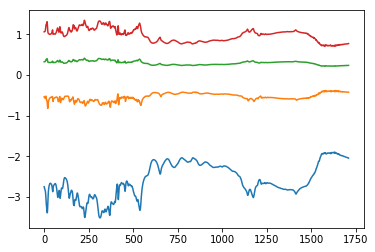

In [117]:
# forward = model.forward(test_spc)
# ret_layer = forward[2]

# print ret_layer.shape
# # matplotlib.pyplot.plot(ret_layer.data.reshape(3,-1)[0], ".")
x = chainer.functions.reshape(test_spc, (47, 1, -1, 1))
print x.shape
# ret_layer = chainer.functions.relu(model.conv1(x)).data
ret_layer = (model.conv1(x)).data

tmp = chainer.functions.reshape(ret_layer, (47, 4, -1)).data
print tmp[0].shape
matplotlib.pyplot.plot(tmp[0].T)


ValueError: x and y can be no greater than 2-D, but have shapes (4,) and (4, 1713, 3)

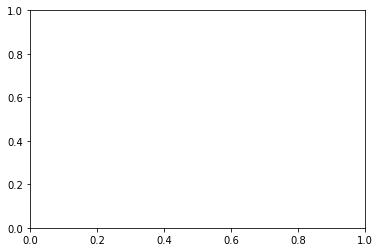

In [78]:
matplotlib.pyplot.plot(ret_layer[0])

In [32]:
train_iter.reset()
test_iter.reset()

train_preds = []
test_preds = []
train_refs = []
test_refs = []

while -1:
    train_batch = train_iter.next()
    train_spc, train_ref = concat_examples(train_batch)  # Train Dataset

    with chainer.using_config('train', False):
        train_pred = chainer.cuda.to_cpu(
            model.forward(train_spc)[0].data).T[0].tolist()
    train_preds = train_preds + train_pred
    train_refs = train_refs + list(train_ref.T[0])

    if train_iter.is_new_epoch:
        break

while -1:
    test_batch = test_iter.next()
    test_spc, test_ref = concat_examples(test_batch)  # Test Dataset

    with chainer.using_config('train', False):
        test_pred = chainer.cuda.to_cpu(
            model.forward(test_spc)[0].data).T[0].tolist()
    test_preds = test_preds + test_pred
    test_refs = test_refs + list(test_ref.T[0])

    if test_iter.is_new_epoch:
        break

train_preds = numpy.array(train_preds)
train_refs = numpy.array(train_refs)
test_preds = numpy.array(test_preds)
test_refs = numpy.array(test_refs)


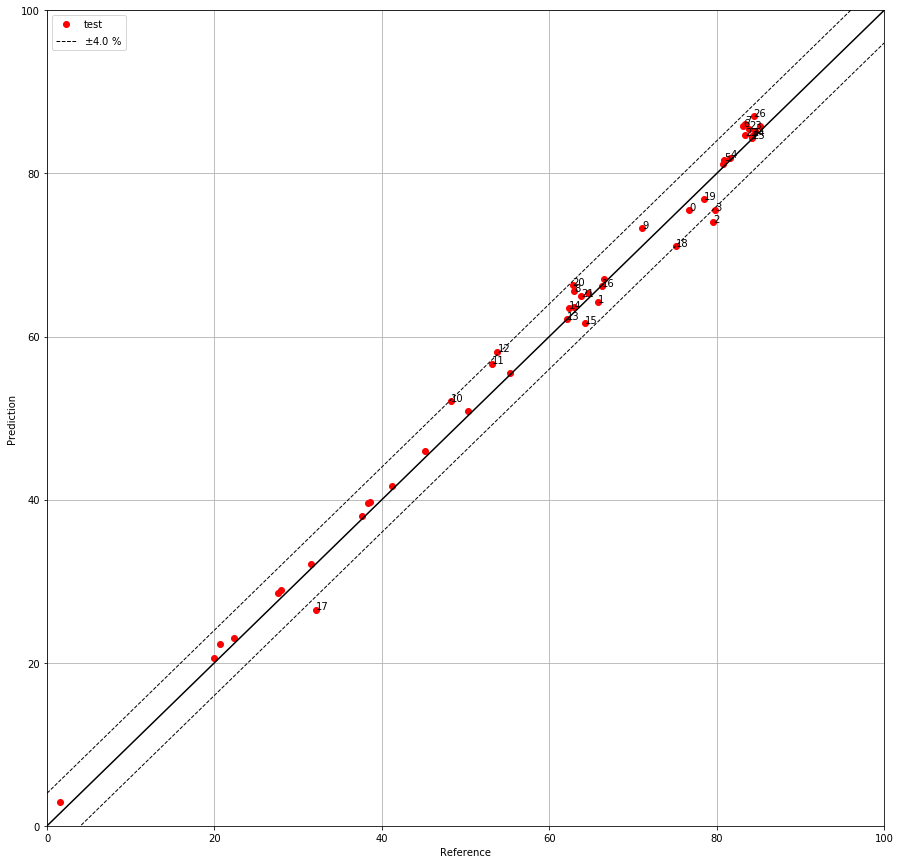

In [33]:
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15))
# ax.plot(numpy.array(train_refs) * 100,
#         numpy.array(train_preds) * 100,
#         "o", label="traing")
ax.plot(numpy.array(test_refs) * 100,
        numpy.array(test_preds) * 100,
        "ro", label="test")


for i in range(27):
    ax.text(numpy.array(test_refs)[i] * 100,
            numpy.array(test_preds)[i] * 100,
            "%d" % (i), fontsize=10)
#     ax.text(numpy.array(test_refs)[i] * 100,
#             numpy.array(test_preds)[i] * 100,
#             "%d - %1.1f" % (i, test_ref[i]*100), fontsize=10)


ax.plot([0, 100], [0, 100], "k-")
ax.plot([0, 100], [4.0, 104.0], "k--", lw=1, label=r"$\pm$4.0 %")
ax.plot([0, 100], [-4.0, 96.0], "k--", lw=1)

ax.legend()

ax.set_xlabel("Reference")
ax.set_ylabel("Prediction")
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

ax.grid()






In [40]:
import yaml
conf_yaml = "../01_WIP/chainer-spectroscopic-measurement/net_config/deepnet_config.yaml"
with open(conf_yaml, "r") as conf:
    out = yaml.load(conf)
data = out["deepnet1c"]

with open("tmp.txt", "w") as f:
    f.write("[%s] configure:: network_stracture\n" % (now()))
    f.write(yaml.dump(data))


In [41]:
out

{'deepnet1b': {'affine': 1600,
  'channels': '8,8,4,4',
  'dropout': '0.0, 0.0, 0.0, 0.5',
  'kernel': '3,3,3,3',
  'pooling': '2,2,2,2'},
 'deepnet1c': {'affine': 300,
  'channels': '2,2,2,2,4,4',
  'dropout': 0.0,
  'kernel': 3,
  'pooling': 2},
 'graph_00': {'xlabel': 'Reference Value of polyester[-]',
  'xlim': '0, 100',
  'ylabel': 'Predicted Value of polyester[-]',
  'ylim': '0, 100'},
 'network': {'affine': 800,
  'channels': '40,20,10,5',
  'dropout': '0.0, 0.0, 0.0, 0.3',
  'kernel': '3,3,3,3',
  'pooling': '2,2,2,2'},
 'network2': {'affine': '4096, 4096',
  'channels': '64,64,128,128,256,256,256,512,512,512,512,512,512',
  'dropout': '0.0, 0.0, 0.0, 0.0',
  'kernel': '3,3,3,3,3,3,3,3,3,3,3,3,3',
  'pooling': '2,2,2,2,2'},
 'optimizer': {'method': 'Adam', 'param': '0.001, 0.9, 0.999, 1e-8'}}

In [112]:
# {affine: 800, channels: '2,2,3,3,4,4', dropout: 0.0, kernel: 5, pooling: 2}


out2 = {'deepnet1c': {"affine": 300,
                      "channels": '2,2,2,2,4,4',
                      "dropout": 0.0,
                      "kernel": 3,
                      "pooling": 2},
       }

In [9]:
from models import deepnet1c

out2 = {'deepnet1c': {"affine": 300,
                      "channels": '4,4,8,8,16,16',
                      "dropout": 0.0,
                      "kernel": 3,
                      "pooling": 2}
,
       }
model = deepnet1c(conf_yaml=cnf_file,use_network="deepnet1c",
                 net_yaml=out2)
chainer.serializers.load_hdf5("./model_id.103506.deepnet1c.hdf5", model)



In [114]:
net_name = "deepnet1c" 
out = out2
cnf_channels = numpy.array(
    out[net_name]["channels"].split(","), dtype=int)
cnf_kernel = out[net_name]["kernel"]  # kernel sizeは単一
cnf_pooling = out[net_name]["pooling"]  # pooling sizeは単一
cnf_affine = out[net_name]["affine"]
cnf_dropout = numpy.float32(out[net_name]["dropout"])


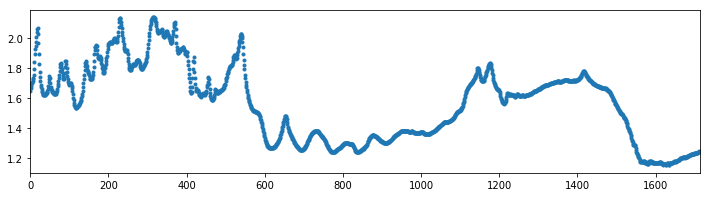

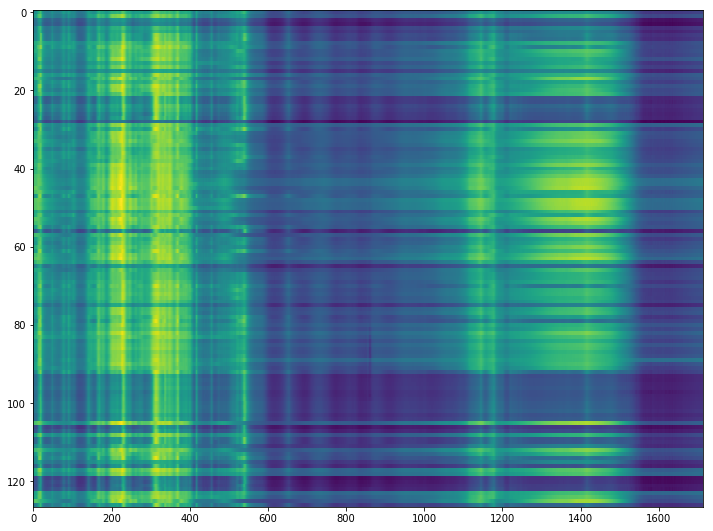

In [34]:
matplotlib.pyplot.figure(figsize=(12,3))
matplotlib.pyplot.plot(data[:,0], ".")
matplotlib.pyplot.xlim(0,1713)

matplotlib.pyplot.figure(figsize=(12,12))
matplotlib.pyplot.imshow(data.reshape(1713, -1).T, aspect="10")